<h3>Author: Kaiser Slocum</h3>
<h3>Date Last Edited: 3/10/2022</h3>
<h3>All Rights Reserved</h3>
This is a model that combines: 5 operators (addition, multiplication, division, subtraction, equal) and a decimal point, all uppercase and lowercase letters of the English alphabet (a-z)(A-Z), all ten digits (0-9)

In [1]:
#This is for notebooks that don't have torchplot installed
!pip install torchplot
# Here we are importing the necessary libraries
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
import torchplot as tplt
import numpy as np
import torch.optim as optim

from torch import nn
from torch import optim
from torchvision import datasets, models, transforms
from tqdm import tqdm
from torch.utils.data import DataLoader, sampler, random_split, ConcatDataset

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("We will be using the:", device)

  Installing build dependencies ... - \ | / done
  Getting requirements to build wheel ... - \ done
  Preparing metadata (pyproject.toml) ... - \ done
  Created wheel for torchplot: filename=torchplot-0.2.0-py3-none-any.whl size=8327 sha256=3d346f39a081bffc875ee981d5f2e77c6e2ca65fd50be9e350f942dc95528934
  Stored in directory: /root/.cache/pip/wheels/10/2c/51/20e41cb36ecf77321dfab07bc2119951e030e717222d78d742
Successfully built torchplot
PyTorch Version:  1.9.1
Torchvision Version:  0.10.1
We will be using the: cuda


In [2]:
transformAlexNet = transforms.Compose([
            transforms.Grayscale(num_output_channels=3),
            transforms.Resize(227),
            transforms.CenterCrop(227),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])
transformLeNet = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.Resize(28),
            transforms.CenterCrop(28),  
            transforms.ToTensor()])
# The only reason we want to use an invert is so that we have white on black for both datasets!
transformLeNetInvert = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.Resize(28),
            transforms.CenterCrop(28),
            transforms.RandomInvert(1),
            transforms.ToTensor()])

emnist_dataset = datasets.EMNIST(root='./', split='balanced', train=True, download=True, transform=transformLeNet)
math_dataset   = datasets.ImageFolder('../input/customarchive/CustomArchive/dataset', transform=transformLeNetInvert)

complete_dataset = ConcatDataset([math_dataset, emnist_dataset])
train_dataset = DataLoader(complete_dataset,batch_size=100,shuffle=True)

  0%|          | 0/561753746 [00:00<?, ?it/s]

Extracting ./EMNIST/raw/gzip.zip to ./EMNIST/raw


/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /usr/local/src/pytorch/torch/csrc/utils/tensor_numpy.cpp:174.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


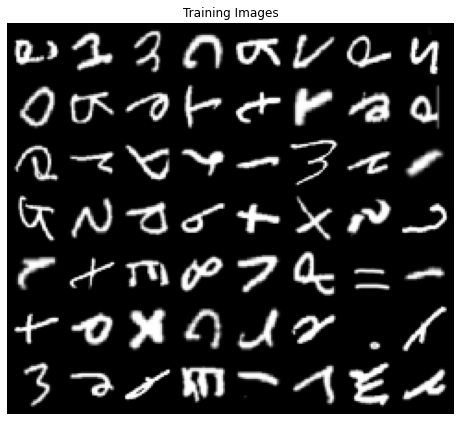

In [3]:
real_batch = next(iter(train_dataset))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
import torchvision.utils as vutils
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:56], padding=2, normalize=True).cpu(),(1,2,0)))

In [4]:
# Requires the LeNet transformations and runs fairly fast
class LeNet(nn.Module):
    def __init__(self, nclasses=68):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6,5,padding=2)
        self.conv2 = nn.Conv2d(6,16,5, padding=0)
        self.fc1 = nn.Linear(5*5*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84,nclasses)        
    def forward(self, x):
        x = torch.sigmoid(self.conv1(x))
        x =  nn.MaxPool2d(kernel_size=2, stride=2)(x)
        x = torch.sigmoid(self.conv2(x))
        x =  nn.MaxPool2d(kernel_size=2, stride=2)(x)        
        x = x.view(-1, 5*5*16)        
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = self.fc3(x)
        return x

In [5]:
# Requires the AlexNet transformations (i.e. bigger images and 3 channels) and runs much slower than LeNet
class AlexNet(nn.Module):
    def __init__(self, nclasses=68):
        super(AlexNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels= 96, kernel_size= 11, stride=4, padding=0 )
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride= 1, padding= 2)
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride= 1, padding= 1)
        self.conv4 = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.fc1  = nn.Linear(in_features= 9216, out_features= 4096)
        self.fc2  = nn.Linear(in_features= 4096, out_features= 4096)
        self.fc3 = nn.Linear(in_features=4096 , out_features=nclasses)
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = self.maxpool(x)
        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [6]:
# Will append the test accuracy to the test_accuracy_history[]
def evaluate(model, test_data, test_accuracy_history, test_image_datasets_len):
    with torch.no_grad():
        test_accuracy = 0
        for (data, label) in test_data:
            data = data.to(device)
            label = label.to(device)
            out = model(data)
            answers = out.max(dim=1)[1]
            test_accuracy += (answers == label).sum()
    test_accuracy = test_accuracy / test_image_datasets_len * 100
    test_accuracy_history.append(test_accuracy)
    return test_accuracy
# Does not accept the test_accuracy_history[]
# Used for simply displaying accuracy of a model
def evaluateAcc(model, test_data, test_data_len):
    with torch.no_grad():
        test_accuracy = 0
        for (data, label) in test_data:
            data = data.to(device)            
            label = label.to(device)
            out = model(data)            
            answers = out.max(dim=1)[1]
            test_accuracy += (answers == label).sum()
    test_accuracy = test_accuracy / test_data_len * 100
    return test_accuracy

In [7]:
def super_plotter(loss_history, test_accuracy_history, train_accuracy_history):
    # Plot the loss per iteration
    tplt.plot(loss_history, label="Loss")
    tplt.title("Neural Network Loss")
    tplt.xlabel("Number of iterations")
    tplt.ylabel("Loss History")
    tplt.legend(loc='upper right')
    tplt.show()
    # Plot the accuracy per epoch
    tplt.plot(test_accuracy_history, label="Test")
    tplt.plot(train_accuracy_history, label="Train")
    tplt.title("Neural Network Accuracy")
    tplt.xlabel("Epoch Number")
    tplt.ylabel("Accuracy")
    tplt.legend(loc='lower right')
    tplt.show()

In [8]:
def super_model_trainer(model, train_dataset, train_dataloader, test_dataset, test_dataloader, batch_size, optimizer, nepochs): 
    model.train()
    loss_history = []
    test_accuracy_history = []
    train_accuracy_history = []
    loss = torch.Tensor([0])
    for epoch in tqdm(range(nepochs), desc=f"Epoch", unit="epoch", disable=False):
        accuracy = 0
        for (data, label) in tqdm(train_dataloader, desc="iteration", unit="%", disable=True):
            # Here we clear the gradients
            optimizer.zero_grad(set_to_none=True)        
            # We need to make sure the tensors are on the same device as our model
            data = data.to(device)
            label = label.to(device)
            out = model(data)        
            loss = LossFunction(out, label)        
            loss.backward() # This function calculates all our gradients
            optimizer.step() # This function does our gradient descent with those gradients
            loss_history.append(loss.item())
            answers = out.max(dim=1)[1]
            accuracy += (answers == label).sum()
        # Append the training accuracy
        accuracy = accuracy / len(train_dataset)*100
        train_accuracy_history.append(accuracy)
    
        #let's get the test accuracy to see how well it generalizes
        test_accuracy = evaluate(model, test_dataloader, test_accuracy_history, len(test_dataset))
        #Print the results
        print(f"Epoch: {epoch} \n Loss: {loss.item()} \n Train Accuracy: {accuracy:.2f}% \n Test Accuracy: {test_accuracy:.2f}%")
    super_plotter(loss_history, test_accuracy_history, train_accuracy_history)

AlexNet(
  (conv1): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=9216, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=4096, bias=True)
  (fc3): Linear(in_features=4096, out_features=53, bias=True)
)


Epoch:  20%|██        | 1/5 [07:05<28:20, 425.15s/epoch]

Epoch: 0 
 Loss: 0.3096145689487457 
 Train Accuracy: 75.31% 
 Test Accuracy: 83.89%


Epoch:  40%|████      | 2/5 [13:25<19:55, 398.52s/epoch]

Epoch: 1 
 Loss: 0.35507932305336 
 Train Accuracy: 86.21% 
 Test Accuracy: 86.30%


Epoch:  60%|██████    | 3/5 [19:43<12:58, 389.32s/epoch]

Epoch: 2 
 Loss: 0.4722461402416229 
 Train Accuracy: 87.37% 
 Test Accuracy: 86.76%


Epoch:  80%|████████  | 4/5 [26:01<06:25, 385.05s/epoch]

Epoch: 3 
 Loss: 0.37296953797340393 
 Train Accuracy: 88.27% 
 Test Accuracy: 86.71%


Epoch: 100%|██████████| 5/5 [32:16<00:00, 387.29s/epoch]

Epoch: 4 
 Loss: 0.24501372873783112 
 Train Accuracy: 88.40% 
 Test Accuracy: 87.14%


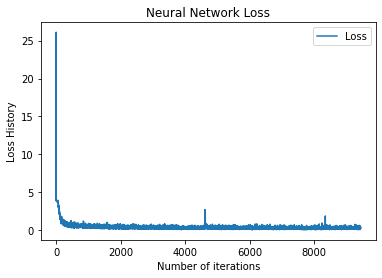

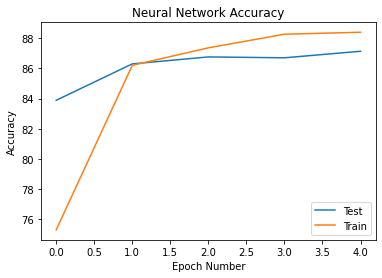

In [9]:
# Let's set up some parameters
learning_rate=0.001
nepochs = 5
nclasses=53
batch_size = 64

transformAlexNet = transforms.Compose([
            transforms.Grayscale(num_output_channels=3),
            transforms.Resize(227),
            transforms.CenterCrop(227),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

transformLeNet = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.Resize(28),
            transforms.CenterCrop(28), 
            transforms.ToTensor()])

# We'll use AlexNet here, but you could choose LeNet
model = AlexNet(nclasses).to(device)
transform = transformAlexNet

optimizer = torch.optim.Adam(model.parameters(), learning_rate)
LossFunction = nn.CrossEntropyLoss()
print(model)

# EMNIST train and test datasets
emnist_train_dataset = datasets.EMNIST(root='./', split='balanced', train=True, download=True, transform=transform)
emnist_test_dataset = datasets.EMNIST(root='./', split='balanced', train=False, download=False, transform=transform)

# Digit/Variable train and test datasets
m_dataset = datasets.ImageFolder('../input/digitarchive/dataset', transform=transform)
m_train_dataset, m_test_dataset = random_split(m_dataset, [int(len(m_dataset)*0.80), int(len(m_dataset)-int(len(m_dataset)*0.80))])

# Operator and Decimal train and test datasets
math_dataset = datasets.ImageFolder('../input/customarchive/CustomArchive/dataset', transform=transform)
math_train_dataset, math_test_dataset = random_split(math_dataset, [int(len(math_dataset)*0.80), int(len(math_dataset) - int(len(math_dataset)*0.80))])

# You can also replace all the three above datasets by just using the custom one I created below
# However it's very slow and clunky which means it generally performs worse
#dataset = datasets.ImageFolder('../input/emnistbalancedoperator/EMNIST', transform=transform)
#train_dataset, test_dataset = random_split(dataset, [int(len(dataset)*0.75), int(len(dataset) - int(len(dataset)*0.75))])

# Combine the train and test datasets and shuffle them together
train_dataset = ConcatDataset([math_train_dataset, emnist_train_dataset, m_train_dataset])
train_dataloader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
test_dataset = ConcatDataset([math_test_dataset, emnist_test_dataset, m_test_dataset])
test_dataloader = DataLoader(test_dataset,batch_size=batch_size,shuffle=True)

#Training 
super_model_trainer(model, train_dataset, train_dataloader, test_dataset, test_dataloader, batch_size, optimizer, nepochs)

In [10]:
# Here we'll test the accuracy on all of the test cuts of the datasets
test_data_emnist = DataLoader(emnist_test_dataset, batch_size=batch_size, shuffle=True)
math_test_dataset = datasets.ImageFolder('../input/customarchive/CustomArchive/dataset', transform=transform)
test_data_math = DataLoader(math_test_dataset, batch_size=batch_size, shuffle=True)
m_dataset = datasets.ImageFolder('../input/digitarchive/dataset', transform=transform)
test_data_m = DataLoader(m_dataset, batch_size=batch_size, shuffle=True)

test_accuracy_emnist = evaluateAcc(model, test_data_emnist, len(emnist_test_dataset))
test_accuracy_math = evaluateAcc(model, test_data_math, len(math_test_dataset))
test_accuracy_m = evaluateAcc(model, test_data_m, len(m_dataset))

#Print the results
print(f"EMNIST Accuracy: {test_accuracy_emnist:.2f}%")
print(f"Operator Accuracy: {test_accuracy_math:.2f}%")
print(f"Full Archive Accuracy: {test_accuracy_m:.2f}%")

EMNIST Accuracy: 87.00%
Operator Accuracy: 98.03%
Full Archive Accuracy: 87.86%
